In [51]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load restaurant inspection data
engine = create_engine("sqlite:///data/restaurants.db")
df = pd.read_sql("SELECT * FROM Inspection_data", engine, parse_dates=["INSPECTION DATE"])
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,41154379,ALMONDINE,Brooklyn,85,WATER STREET,11201,7187975026,,2018-07-26,P,...,04/20/2021,Cycle Inspection / Initial Inspection,40.703263653864,-73.991225054059,302,33,002100,3000021,3000260038,BK38
1,50036502,FANCY JUICE,Manhattan,69,1 AVENUE,10003,2122281256,,2017-07-25,D,...,04/20/2021,Cycle Inspection / Initial Inspection,40.725380589145,-73.986910764439,103,02,003800,1006217,1004460035,MN22
2,50001471,ROY'S RESTAURNT & BAR,Bronx,880,EAST TREMONT AVENUE,10460,9174718937,,2017-12-14,G,...,04/20/2021,Cycle Inspection / Initial Inspection,40.842783543227,-73.885844527342,206,17,036502,2010159,2029600070,BX17
3,50069481,MO MO SUSHI & RAMEN,Brooklyn,644,FLATBUSH AVENUE,11225,7182828890,,2020-01-28,D,...,04/20/2021,Cycle Inspection / Re-inspection,40.657622494297,-73.960339831275,309,40,079802,3114637,3050260194,BK60
4,41382830,THE PERFECT PINT,Manhattan,203,EAST 45 STREET,10017,2128678159,,2018-05-24,D,...,04/20/2021,Cycle Inspection / Initial Inspection,40.752537516118,-73.972673881171,106,04,009000,1037598,1013190104,MN19


In [10]:
# Cleaning
df['rodent_violation'] = np.where(df["VIOLATION CODE"] == "04K", 1, 0)
df['Year'] = df["INSPECTION DATE"].apply(lambda x: x.year)
df['Month'] = df["INSPECTION DATE"].apply(lambda x: x.month)
df['Month_year'] = pd.to_datetime(df["INSPECTION DATE"]).dt.to_period('M')
df.replace("",np.nan, inplace=True)
df.drop(columns=["BUILDING", "STREET", "PHONE", "CUISINE DESCRIPTION", "VIOLATION CODE", 
                 "VIOLATION DESCRIPTION", "CRITICAL FLAG", "GRADE DATE", "RECORD DATE", 
                 "INSPECTION TYPE", "NTA"], inplace=True)
df.dropna(how="any", inplace=True)
df.shape

(193608, 19)

In [11]:
df.head()

,CAMIS,DBA,BORO,ZIPCODE,INSPECTION DATE,ACTION,SCORE,GRADE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,rodent_violation,Year,Month,Month_year
1,50036502,FANCY JUICE,Manhattan,10003,2017-07-25,D,11,A,40.725380589145,-73.986910764439,103,02,003800,1006217,1004460035,0,2017,7,2017-07
3,50069481,MO MO SUSHI & RAMEN,Brooklyn,11225,2020-01-28,D,11,A,40.657622494297,-73.960339831275,309,40,079802,3114637,3050260194,0,2020,1,2020-01
4,41382830,THE PERFECT PINT,Manhattan,10017,2018-05-24,D,9,A,40.752537516118,-73.972673881171,106,04,009000,1037598,1013190104,0,2018,5,2018-05
5,50077330,QUALITY FOOD CHINESE RESTAURANT,Bronx,10465,2019-01-22,D,13,A,40.829548925682,-73.825156690914,210,13,016200,2076704,2054270098,0,2019,1,2019-01
7,50039082,EL CASTILLO DE JAGUA II,Manhattan,10002,2019-09-27,U,26,B,40.714573786457,-73.982082786248,103,01,000202,1003741,1002880033,0,2019,9,2019-09


In [12]:
df.Year.value_counts()

2019    71426
2018    59363
2017    37664
2020    16479
2016     8543
2015       80
2014       23
2011       10
2012       10
2013        9
2021        1
Name: Year, dtype: int64

In [13]:
df2 = pd.read_sql("""SELECT * FROM calls_data WHERE "Complaint Type"="Rodent";""", engine, parse_dates=["Created Date"])
df2.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,39981109,2018-08-10,08/15/2018 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other (Explain Below),11209,,...,,,,,,,,40.63372397873045,-74.02388342767199,"(40.63372397873045, -74.02388342767199)"
1,39981156,2018-08-10,08/10/2018 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11372,33-33 82ND ST,...,,,,,,,,40.754279636875594,-73.88499034099145,"(40.754279636875594, -73.88499034099145)"
2,39981569,2018-08-11,08/11/2018 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Signs of Rodents,3+ Family Apt. Building,10032,478 WEST 158 STREET,...,,,,,,,,40.83300208979604,-73.94044685663981,"(40.83300208979604, -73.94044685663981)"
3,39981599,2018-08-12,08/23/2018 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other (Explain Below),11206,167 HEYWARD STREET,...,,,,,,,,40.7025703051472,-73.95477695269145,"(40.7025703051472, -73.95477695269145)"
4,39981657,2018-08-11,08/17/2018 03:40:41 PM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other (Explain Below),11221,600 QUINCY STREET,...,,,,,,,,40.68854430730697,-73.9368041756644,"(40.68854430730697, -73.9368041756644)"


In [14]:
df2 = df2[df2["Created Date"] > "1/1/2011"]
df2.shape

(285789, 41)

In [15]:
df2 = df2[["Created Date", "Descriptor", "Incident Zip", "Borough"]]
df2['Rodent_sighting'] = np.where(df2.Descriptor == "Condition Attracting Rodents", 0, 1)
df2['Year'] = df2['Created Date'].apply(lambda x: x.year)
df2['Month'] = df2['Created Date'].apply(lambda x: x.month)
df2['Month_year'] = pd.to_datetime(df2['Created Date']).dt.to_period('M')
df2.replace("",np.nan, inplace=True)
df2.sample(5)

,Created Date,Descriptor,Incident Zip,Borough,Rodent_sighting,Year,Month,Month_year
231499,2016-04-28 00:00:00,Rat Sighting,11216,BROOKLYN,1,2016,4,2016-04
91789,2021-02-02 09:15:56,Rat Sighting,11238,BROOKLYN,1,2021,2,2021-02
260229,2017-02-19 00:00:00,Rat Sighting,10462,BRONX,1,2017,2,2017-02
43431,2019-05-20 08:11:11,Rat Sighting,11231,BROOKLYN,1,2019,5,2019-05
116700,2012-04-18 00:00:00,Rat Sighting,11412,QUEENS,1,2012,4,2012-04


In [16]:
df2.dropna(how='any', inplace=True)
df2.shape

(285247, 8)

In [20]:
call_df = (df2[["Incident Zip", "Month_year", "Rodent_sighting"]]
 .groupby(["Incident Zip","Month_year"])
 .sum().sort_values(by="Rodent_sighting").reset_index())
call_df.sample(5)

,Incident Zip,Month_year,Rodent_sighting
12144,10029,2013-03,9
8398,10001,2016-07,5
10290,10065,2017-01,7
1124,10308,2017-12,1
6544,11375,2015-01,4


In [21]:
new_df = pd.merge(df, call_df, how="left", left_on=['ZIPCODE', 'Month_year'], right_on = ['Incident Zip', 'Month_year'])
print(new_df.shape)
new_df.sample(5)

(193608, 21)


,CAMIS,DBA,BORO,ZIPCODE,INSPECTION DATE,ACTION,SCORE,GRADE,Latitude,Longitude,...,Council District,Census Tract,BIN,BBL,rodent_violation,Year,Month,Month_year,Incident Zip,Rodent_sighting
128703,50068060,TASTE OF PUNJAB,Queens,11419,2019-11-13,U,19,B,40.696090930974,-73.81335134656,...,28,015200,4200383,4094820116,0,2019,11,2019-11,11419,5.0
101283,50004900,C J's BAR & LOUNGE,Queens,11417,2018-01-25,U,10,A,40.671808514998,-73.843091788689,...,32,008800,4248625,4115290051,0,2018,1,2018-01,11417,3.0
117745,50080755,JANCHI MYEONGA,Queens,11354,2019-08-29,F,16,B,40.763248708615,-73.814245391769,...,20,116700,4114040,4050310022,0,2019,8,2019-08,11354,12.0
31312,50043710,ZURILEE,Brooklyn,11226,2018-03-16,D,12,A,40.654350455788,-73.959592155673,...,40,079602,3116190,3050640014,0,2018,3,2018-03,11226,34.0
192154,50098816,R&C FIT GRILL,Queens,11368,2019-11-12,D,9,A,40.750833891152,-73.858319943192,...,21,040100,4440230,4019960001,0,2019,11,2019-11,11368,4.0


In [22]:
new_df.columns

Index(['CAMIS', 'DBA', 'BORO', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'SCORE',
       'GRADE', 'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'BBL', 'rodent_violation', 'Year', 'Month',
       'Month_year', 'Incident Zip', 'Rodent_sighting'],
      dtype='object')

In [24]:
new_df.drop(columns=["CAMIS", "DBA","INSPECTION DATE","ACTION", "SCORE", "GRADE", "Latitude", "Longitude",
                     "Community Board", "Council District", "Census Tract", "BIN", "BBL", 
                     "Month_year", "Incident Zip"], inplace=True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193608 entries, 0 to 193607
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   BORO              193608 non-null  object 
 1   ZIPCODE           193608 non-null  object 
 2   rodent_violation  193608 non-null  int64  
 3   Year              193608 non-null  int64  
 4   Month             193608 non-null  int64  
 5   Rodent_sighting   188074 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 10.3+ MB


In [25]:
new_df.dropna(how='any',inplace=True)
new_df.shape

(188074, 6)

In [26]:
# Dummy variables
boro_dummies = pd.get_dummies(new_df.BORO, prefix='BORO', drop_first=True)
new_df = new_df.join(boro_dummies)
new_df.drop(['BORO'], inplace=True, axis=1)
new_df.head()

,ZIPCODE,rodent_violation,Year,Month,Rodent_sighting,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island
0,10003,0,2017,7,11.0,0,1,0,0
1,11225,0,2020,1,13.0,1,0,0,0
2,10017,0,2018,5,1.0,0,1,0,0
3,10465,0,2019,1,1.0,0,0,0,0
4,10002,0,2019,9,15.0,0,1,0,0


In [53]:
new_df.to_csv("./data/model_data.csv")

# Classification Model

In [54]:
X, y= new_df.drop(['rodent_violation'], axis=1), new_df['rodent_violation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
# Create classifiers
lr = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=100)
svc = LinearSVC(C=1.0)

In [56]:
#Logistic Regression
lr.fit(X_train, y_train)

LogisticRegression()

In [57]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9948756804179212
0.9951083344410474


In [58]:
from sklearn.metrics import precision_score
y_pred = lr.predict(X_test)
precision_score(y_test, y_pred)

0.0

In [59]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.0

In [60]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.0

In [61]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [62]:
probs = rfc.predict_proba(X_test)

In [63]:
probs

array([[1.        , 0.        ],
       [0.97734619, 0.02265381],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.97669384, 0.02330616],
       [0.98123959, 0.01876041]])

In [64]:
y_pred = rfc.predict(X_test)

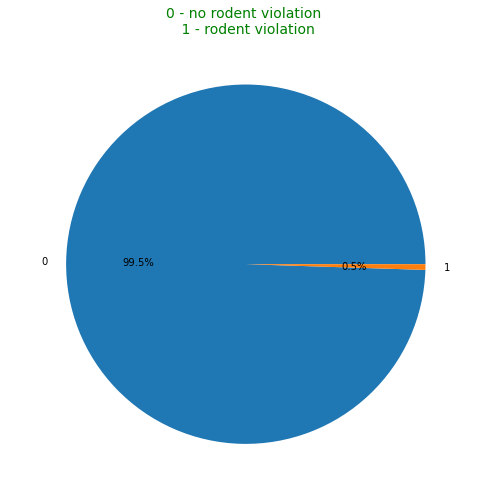

In [66]:
plt.figure(figsize=(7,7))
y.value_counts().plot.pie(ylabel=' ', autopct='%0.1f%%')
plt.title(f'0 - no rodent violation \n 1 - rodent violation', size=14, c='green')
plt.tight_layout();

In [70]:
y.value_counts()

0    187119
1       955
Name: rodent_violation, dtype: int64

The dataset distribution is highly imbalanced, which makes prediction harder